# Severe Weather - Modeling

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
color_choice4 = 'blue'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer

## Load the data



In [2]:
# load the data
X_train = pd.read_parquet("../Data/X_train.pqt")
X_test = pd.read_parquet("../Data/X_test.pqt")
y_train = pd.read_parquet("../Data/y_train.pqt") 
y_test = pd.read_parquet("../Data/y_test.pqt")

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

eval_set = [(X_train, y_train), (X_test, y_test)]

#df = pd.read_parquet("../Data/all_storm_data11.pqt")

# <font color='orange'>Random Forest Model</font>


In [3]:
#rf_reg = RandomForestRegressor(**random_search.best_params_, random_state=1234)
rf_reg = RandomForestRegressor(random_state=1234, n_estimators=100, n_jobs=-1)
rf_reg.fit(X_train, y_train.values.ravel())

y_pred = rf_reg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  10,192.1
MSE:  2,908,505,924.7
RMSE: 53,930.6
MAPE:  13,851,197,322,201,710,592.0

TEST:
MAE:  27,984.8
MSE:  19,156,222,167.3
RMSE: 138,406.0
MAPE:  42,047,149,723,784,093,696.0

MAE DIFF: 175%


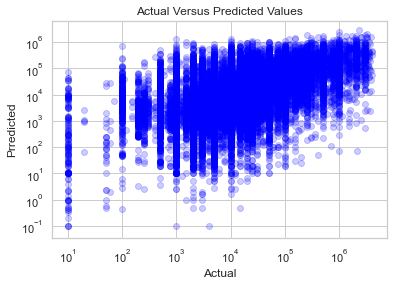

In [4]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


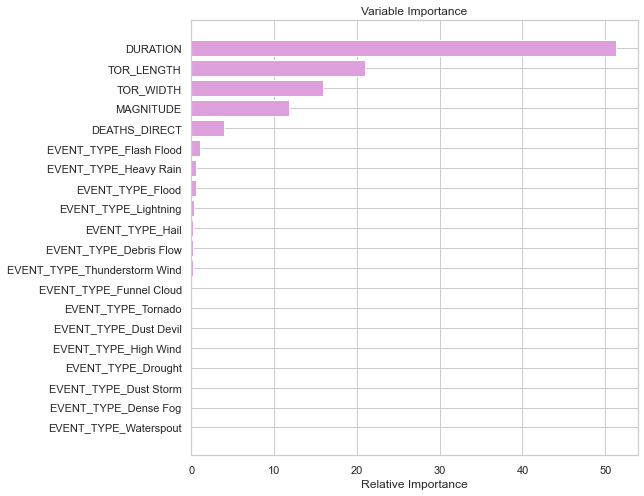

In [5]:
feature_importance = rf_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Now hyperparameter tuning

In [6]:
# set the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [7]:
#markdown since it takes so long to run
# %%time
# random_search = RandomizedSearchCV(RandomForestRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [8]:
rf_reg_cv = RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=10,
                      n_estimators=150, random_state=1234, n_jobs=-1)
rf_reg_cv.fit(X_train, y_train.values.ravel())

y_pred = rf_reg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  27,156.7
MSE:  17,531,346,006.1
RMSE: 132,406.0
MAPE:  44,126,099,925,681,176,576.0

TEST:
MAE:  27,739.1
MSE:  19,479,915,783.7
RMSE: 139,570.5
MAPE:  43,130,760,644,746,690,560.0

MAE DIFF: 2%


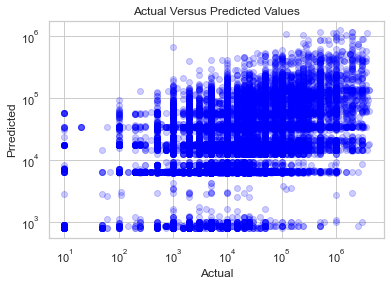

In [9]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


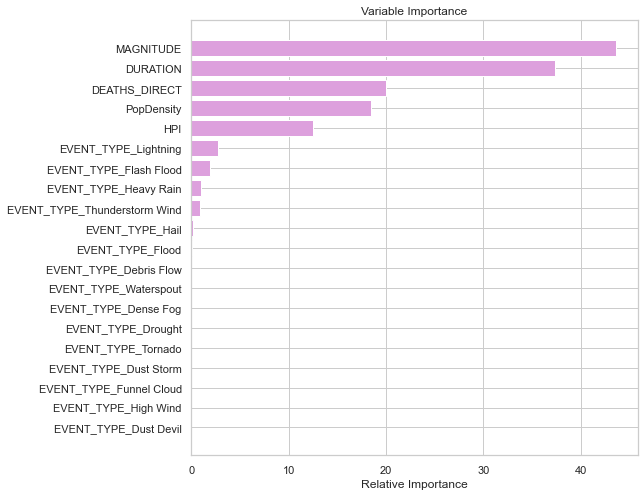

In [10]:
feature_importance = rf_reg_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## cross validation

In [ ]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = RandomForestRegressor(random_state=1234)

#use k-fold CV to evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print(f"{mean(abs(scores)):,.1f}")

/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/mod

# <font color='orange'>Light GBM</font>

In [ ]:
# define the model
lgbm = LGBMRegressor(random_state=1234)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

With this baseline, let's see how we can improve with hyperparameter tuning

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'num_leaves': [10, 30, 50],
    'colsample_bytree': [.3, .5, .8]
}

In [ ]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(LGBMRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [ ]:
# define the model with hyperparamters from random search
lgbm_cv = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234)
lgbm_cv.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = lgbm_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### cross validation

In [ ]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
#model = LGBMRegressor(random_state=1234)
model = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234)


#use k-fold CV to evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print(f"{mean(abs(scores)):,.1f}")

first model: 78,905,701.6

second model: 92,054,440.0

# <font color='orange'>XGBoost</font>


In [ ]:
# define the model
xgbr = XGBRegressor(random_state=1234, early_stopping_rounds=20)
xgbr.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = xgbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [.3, .5, .8],
    'subsample': [.3, .5, .8]
}

In [ ]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(XGBRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel(), eval_set=eval_set)
# print(random_search.best_estimator_)

In [ ]:
# define the model
xgbr_cv = XGBRegressor(random_state=1234,
                       learning_rate=0.1, 
                       max_depth=6, 
                       n_estimators=150,
                       colsample_bytree=.8,
                       subsample=.8)

xgbr_cv.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = xgbr_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### cross validation

In [ ]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = XGBRegressor(random_state=1234)



#use k-fold CV to evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print(f"{mean(abs(scores)):,.1f}")

first model: 78,905,701.6

second model: 92,054,440.0

# <font color='orange'>Tweedie Regression</font>


Steps:
- Filter out claims with zero amount, as the severity model requires strictly positive target values.
- Correct for unreasonable observations (that might be data error) and a few exceptionally large claim amounts
    

In [ ]:
# load the data - this dataset has the zeroes eliminated
### comment out since current run doesn't contain any zeroes nor outliers
# X_train = pd.read_parquet("../Data/X_train_td.pqt")
# X_test = pd.read_parquet("../Data/X_test_td.pqt")
# y_train = pd.read_parquet("../Data/y_train_td.pqt") 
# y_test = pd.read_parquet("../Data/y_test_td.pqt")

# X = pd.concat([X_train, X_test])
# y = pd.concat([y_train, y_test])

In [ ]:
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg = TweedieRegressor(max_iter=500)
tdrg.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = tdrg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
param_grid = {
    'power': [0, 1, 2, 3],
    'max_iter': [50, 100, 150, 200, 250, 500, 1000, 1500]
}

In [ ]:
# %time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(linear_model.TweedieRegressor(),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [ ]:
#tdrg_cv = TweedieRegressor(link='log', power=3, max_iter=50)
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg_cv = TweedieRegressor(link='log', power=1, max_iter=50)
tdrg_cv.fit(X_train, y_train.values.ravel())

# make predictions for test data
y_pred = tdrg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

SCRATCH

In [ ]:
# # Create the fifth model
# model_mlr = sm.OLS(y_train, X_train)

# # Fit the model
# model_mlr_result = model_mlr.fit()

# # Evaluate the model
# model_mlr_result.summary()

In [ ]:
# #df = pd.DataFrame(data) 

# x = X
# y = y

# x = sm.add_constant(x)

# model = sm.OLS(y, x).fit()
# predictions = model.predict(x) 

# print_model = model.summary()
# print(print_model)

https://stackoverflow.com/questions/37144913/getting-valueerror-the-indices-for-endog-and-exog-are-not-aligned